In [43]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline


In [44]:
words = open('names.txt', 'r').read().splitlines()

In [45]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [46]:
block_size = 3
X, Y =[], []
for w in words:

    context = [0]*block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)


In [47]:
# build the dataset

def build_dataset(words):
    block_size = 3
    X, Y =[], []
    for w in words:

        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [48]:
# -------------------- ----------------

In [49]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [ ]:
hidden_size = 200
n_embd = 10
vocab_size = 27

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, hidden_size), generator=g) * (5/3)/((n_embd*block_size)**0.5)
# b1 = torch.randn(hidden_size, generator=g) * 0.01 有归一化的情况下，b1的作用会被bnbias代替掉，使得b1的grad一直为0，导致资源浪费，因此可以不需要b1
W2 = torch.randn((hidden_size, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g)

bngain = torch.ones(hidden_size)
bnbias = torch.zeros(hidden_size)


bnmean_running = torch.zeros((1, hidden_size))
bnstd_running = torch.ones((1, hidden_size))

parameters=[C, W1, W2, b2, bnbias, bngain]

In [51]:

for p in parameters:
    p.requires_grad = True

In [52]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [53]:
lri = []
lossi = []
stepi = []


In [ ]:


for _ in range(200000):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]]
    # Linear layer
    hpreact = emb.view(-1, 30) @ W1
    # BatchNorm layer
    bnmeani = hpreact.mean(0, keepdim = True)
    bnstdi = hpreact.std(0, keepdim = True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias# 批归一化 batch normalize
    with torch.no_grad():
        bnmean_running = 0.999*bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999*bnstd_running + 0.001*bnstdi
    #Non-linearity 非线性化
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Ytr[ix]) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # lri.append(lre[_].item())
    # lossi.append(loss.item())
    lr = 0.1 if _<100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    stepi.append(_)
    lossi.append(loss.item())

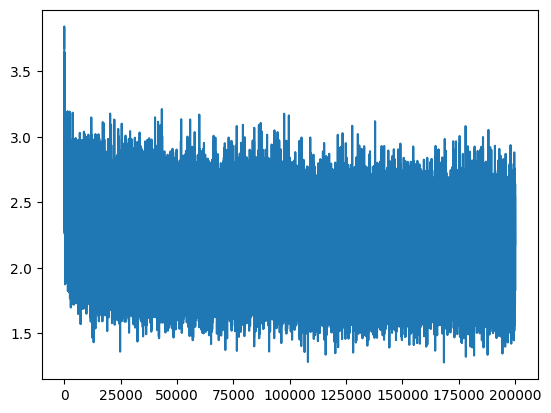

In [14]:
plt.plot(stepi, lossi)

归一化操作中，期待的输入是一个batch，无法用单一的样本去获得输出，因此有了一下操作，让该网络的输出可以是单样本

In [ ]:
with torch.no_grad():# 可以在训练过程中动态维护
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [ ]:
bnmean

In [ ]:
bnmean_running

In [ ]:
@torch.no_grad()
def split_loss(split):
    X, Y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[X]
    hpreact = emb.view(emb.shape[0], -1) @ W1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias# 批归一化 batch normalize
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(split, loss.item())

split_loss('train')
split_loss('val')
split_loss('test')

train 2.0677528381347656
val 2.10795521736145
test 2.105379819869995


In [ ]:
g = torch.Generator().manual_seed(12234234234)

for _ in range(20):

    out = []
    context = [0]*block_size
    while True:
        emb = C[torch.tensor(context)]
        #print(emb.shape)
        hpreact = emb.view(1,-1) @ W1 +b1
        #print(hpreact.shape)
        hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias# 批归一化 batch normalize
        #print(hpreact)
        h = torch.tanh(hpreact)
        #print(h)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix==0:
            break

    print(''.join(itos[i] for i in out))

izell.
ana.
kemiko.
lilyam.
inn.
jaxsiah.
daeli.
rodyn.
karell.
jaelynn.
yureem.
fiston.
chariana.
lynnie.
zaiyah.
cairrett.
atly.
kalli.
zasen.
vian.
